In [45]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [46]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [47]:
NUM_CLASSES = 22

# Dataset reading

In [48]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [49]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [51]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [52]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_4 (Dropout)          (None, 42)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                860       
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_8 (Dense)              (None, 11)                121       
Total params: 1,191
Trainable params: 1,191
Non-trainable params: 0
_________________________________________________________________


In [53]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [54]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [55]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


2022-11-30 03:47:04.761099: W tensorflow/core/framework/op_kernel.cc:1763] OP_REQUIRES failed at sparse_xent_op.cc:90 : Invalid argument: Received a label value of 21 which is outside the valid range of [0, 11).  Label values: 7 1 1 2 10 20 8 10 1 10 16 11 19 10 14 12 8 7 20 14 1 1 20 12 6 9 21 17 16 7 12 18 7 17 1 3 18 9 13 19 16 0 7 8 1 1 20 9 10 3 9 8 13 7 7 3 18 9 0 11 8 7 10 9 10 9 3 21 1 11 13 9 4 12 2 3 16 3 8 9 8 20 19 17 18 7 9 8 10 16 7 8 3 9 9 1 21 21 4 3 7 2 9 9 6 18 8 21 13 17 7 8 18 8 18 8 20 7 2 8 9 8 8 13 2 7 18 15


InvalidArgumentError:  Received a label value of 21 which is outside the valid range of [0, 11).  Label values: 7 1 1 2 10 20 8 10 1 10 16 11 19 10 14 12 8 7 20 14 1 1 20 12 6 9 21 17 16 7 12 18 7 17 1 3 18 9 13 19 16 0 7 8 1 1 20 9 10 3 9 8 13 7 7 3 18 9 0 11 8 7 10 9 10 9 3 21 1 11 13 9 4 12 2 3 16 3 8 9 8 20 19 17 18 7 9 8 10 16 7 8 3 9 9 1 21 21 4 3 7 2 9 9 6 18 8 21 13 17 7 8 18 8 18 8 20 7 2 8 9 8 8 13 2 7 18 15
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at var/folders/l6/y42rn8k11s7067ljfp2y3tw40000gn/T/ipykernel_52385/2889966517.py:1) ]] [Op:__inference_train_function_61828]

Function call stack:
train_function


In [ ]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

8/8 [==============================] - 0s 664us/step - loss: 0.4083 - accuracy: 0.8870


In [ ]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [ ]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[2.1509323e-04 3.2113317e-02 1.4781881e-03 6.2737311e-03 1.2885727e-03
 9.1084803e-07 1.4650874e-06 6.3123991e-04 7.9457712e-01 1.6303965e-01
 3.8076605e-04]
8


# Confusion matrix

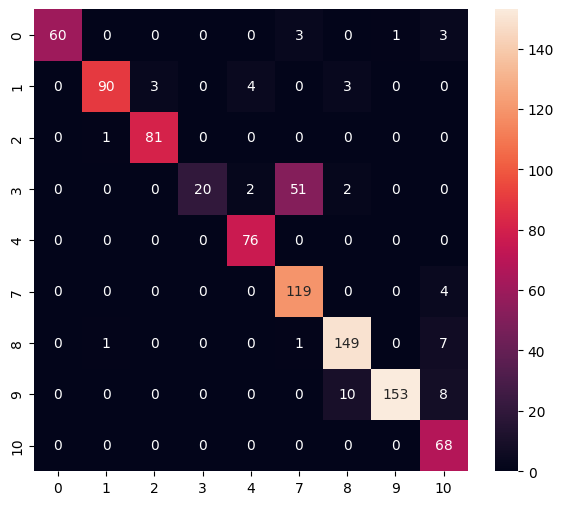

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.94        67
           1       0.98      0.90      0.94       100
           2       0.96      0.99      0.98        82
           3       1.00      0.27      0.42        75
           4       0.93      1.00      0.96        76
           7       0.68      0.97      0.80       123
           8       0.91      0.94      0.93       158
           9       0.99      0.89      0.94       171
          10       0.76      1.00      0.86        68

    accuracy                           0.89       920
   macro avg       0.91      0.87      0.86       920
weighted avg       0.91      0.89      0.88       920



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [ ]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [ ]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/l6/y42rn8k11s7067ljfp2y3tw40000gn/T/tmphesr80h5/assets


INFO:tensorflow:Assets written to: /var/folders/l6/y42rn8k11s7067ljfp2y3tw40000gn/T/tmphesr80h5/assets
2022-11-30 03:10:52.273240: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-11-30 03:10:52.273943: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-11-30 03:10:52.278183: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.002ms.
  function_optimizer: function_optimizer did nothing. time = 0ms.

2022-11-30 03:10:52.407605: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2022-11-30 03:10:52.407630: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.
2022-11-30 03:10:52.488715: I tensorflow/li

6720

# Inference test

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()


In [ ]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [ ]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 160 µs, sys: 74 µs, total: 234 µs
Wall time: 222 µs


In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.1509299e-04 3.2113314e-02 1.4781880e-03 6.2737367e-03 1.2885719e-03
 9.1084877e-07 1.4650873e-06 6.3124049e-04 7.9457706e-01 1.6303970e-01
 3.8076565e-04]
8
